In [1]:
#Цель - обучить RNN на датасете из 8000 имен латиницей, заботать строение RNN cell, алгоритм сэмплирования 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os


In [3]:
start_token = " "

def read_names(path_to_file):
    global start_token
    
    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        names = [start_token + line for line in names]
        return names

In [24]:
with open("names") as f: # датасет на 7944 имени латиницей
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]

In [29]:
print ('n samples = ',len(names),'\n')
for i in names[::1000]:
    print (names.index(i), i)

n samples =  7944 

0  Abagael
1000  Claresta
2000  Glory
3000  Liliane
4000  Prissie
5000  Geeta
6000  Giovanne
7000  Piggy


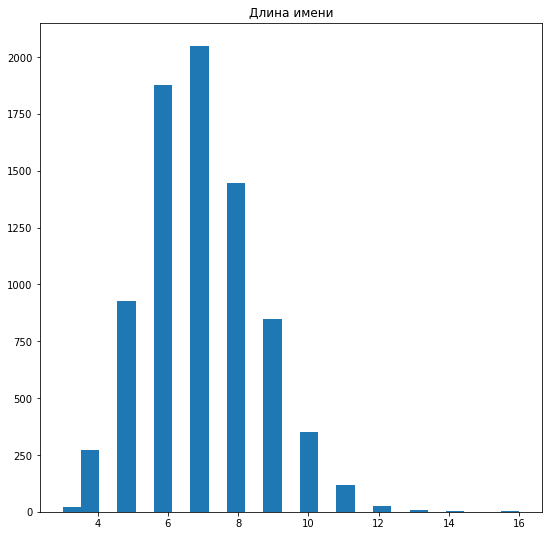

In [34]:
plt.figure(figsize=(9,9))
plt.title('Длина имени')
plt.hist(list(map(len, names)),bins=25);

## Text processing

Сначала нам нужно собрать «словарь» всех уникальных токенов-букв. Затем мы можем кодировать входные данные как последовательность символов.

In [46]:
tokens = set() # мн-во уникальных элементов

for name in names:
    tokens.update(set(name)) # бьем побуквенно каждое имя ==> забираем только уникальные
tokens = list(tokens)

num_tokens = len(tokens) # получаем словарь
print ('num_tokens = ', num_tokens)
print(tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55
['L', 'I', 'm', 'M', 'U', 'v', 'S', 'k', 'w', 'A', 'Y', 'p', 'F', 'c', 'z', 'V', 'O', 'Q', 'u', ' ', 'g', 'C', 'B', 'h', 's', 'P', 'r', "'", 'j', 'x', 'i', 'W', 'l', 'D', 'X', 'd', 'G', 'b', 'E', 'H', 'a', 'y', 'o', 't', 'K', 'J', 'n', 'q', 'Z', 'N', 'f', 'R', '-', 'T', 'e']


### Convert tokens to integers

In [54]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
print(token_to_id)

{'L': 0, 'I': 1, 'm': 2, 'M': 3, 'U': 4, 'v': 5, 'S': 6, 'k': 7, 'w': 8, 'A': 9, 'Y': 10, 'p': 11, 'F': 12, 'c': 13, 'z': 14, 'V': 15, 'O': 16, 'Q': 17, 'u': 18, ' ': 19, 'g': 20, 'C': 21, 'B': 22, 'h': 23, 's': 24, 'P': 25, 'r': 26, "'": 27, 'j': 28, 'x': 29, 'i': 30, 'W': 31, 'l': 32, 'D': 33, 'X': 34, 'd': 35, 'G': 36, 'b': 37, 'E': 38, 'H': 39, 'a': 40, 'y': 41, 'o': 42, 't': 43, 'K': 44, 'J': 45, 'n': 46, 'q': 47, 'Z': 48, 'N': 49, 'f': 50, 'R': 51, '-': 52, 'T': 53, 'e': 54}


In [55]:
for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"
print("Seems alright!")

Seems alright!


In [56]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [57]:
names[:2]

[' Abagael', ' Abagail']

In [58]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[19  9 37 40 20 40 54 32 19]
 [19 36 32 42 26 41 19 19 19]
 [19 25 26 30 24 24 30 54 19]
 [19 36 30 42  5 40 46 46 54]]


# Recurrent neural network

Мы можем переписать рекуррентную нейронную сеть как последовательное применение dense layer для ввода $ x_t $ и предыдущего состояния RNN $ h_t $. 


* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [59]:
import torch, torch.nn as nn
import torch.nn.functional as F
emb_test = nn.Embedding(55, 16)

In [60]:
example_batch = torch.from_numpy(to_matrix(names[::2000])).type(torch.LongTensor)

In [61]:
example_batch.shape

torch.Size([4, 9])

In [62]:
# batch size, seq length, emb dim
emb_test(example_batch).shape

torch.Size([4, 9, 16])

In [63]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [64]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
               
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1) 
        h_next = self.rnn_update(x_and_h) 
        
        h_next = torch.tanh(h_next) 
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) 
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [65]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()  

In [66]:
#nn.CrossEntropyLoss()

### RNN loop


In [67]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [68]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

### Likelihood and gradients

Теперь мы можем обучить нашу нейронную сеть минимизировать crossentropy (максимизировать loglikelyhood).

Чтобы сделать это векторизованным способом, мы берем `batch_ix [:, 1:]` - матрицу индексов токенов, сдвинутую на i-й шаг влево, так что i-й элемент фактически является «следующим токеном» для i-го предсказания.

In [69]:
logp_seq[:, :-1].contiguous()

tensor([[[-3.7687, -3.9110, -4.0210,  ..., -4.2354, -4.1755, -4.1400],
         [-3.9860, -4.0944, -4.2479,  ..., -4.0344, -3.9373, -4.1912],
         [-4.0860, -3.7883, -4.0461,  ..., -4.0217, -4.1894, -4.2624],
         ...,
         [-4.0931, -3.9242, -4.1977,  ..., -4.2283, -3.9877, -4.4318],
         [-3.8131, -3.8000, -4.0261,  ..., -4.2445, -4.1714, -4.1722],
         [-4.0182, -4.2733, -4.1973,  ..., -3.8260, -3.9457, -4.2227]],

        [[-3.7687, -3.9110, -4.0210,  ..., -4.2354, -4.1755, -4.1400],
         [-3.9860, -4.0944, -4.2479,  ..., -4.0344, -3.9373, -4.1912],
         [-4.0860, -3.7883, -4.0461,  ..., -4.0217, -4.1894, -4.2624],
         ...,
         [-4.0931, -3.9242, -4.1977,  ..., -4.2283, -3.9877, -4.4318],
         [-3.8131, -3.8000, -4.0261,  ..., -4.2445, -4.1714, -4.1722],
         [-4.0808, -3.7900, -4.1831,  ..., -4.0675, -4.0882, -4.3178]],

        [[-3.7687, -3.9110, -4.0210,  ..., -4.2354, -4.1755, -4.1400],
         [-3.9860, -4.0944, -4.2479,  ..., -4

In [70]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:] 


loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

In [71]:
loss.backward()

In [72]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [73]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

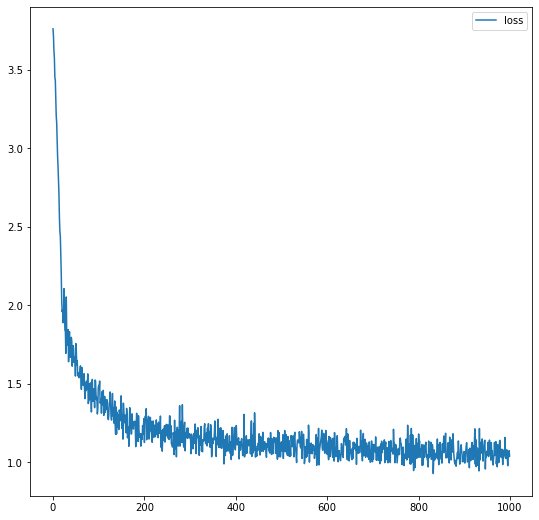

In [74]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()
    
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1] 
    actual_next_tokens = batch_ix[:, 1:] 
    
#     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) 
    
    
    # train with backprop
    loss.backward()
    opt.step()
    

    
    history.append(loss.data.numpy())
    if (i+1)%10==0:
        clear_output(True)
        plt.figure(figsize=(9,9))
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling

In [76]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [81]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Mofdie         
 Juil           
 Jewma          
 Thkend         
 Morbig         
 Haich          
 Bachere        
 Faris          
 Retelma        
 Sierliu        


In [86]:
for _ in range(15):
    print(generate_sample(char_rnn, seed_phrase=' Dep'))

 Depza          
 Dephette       
 Depia          
 Depcola        
 Depvel         
 Depdia         
 Depy           
 Dephann        
 Depelie        
 Depsend        
 DepaIet        
 Dep a          
 Depwis         
 Depne          
 Depoin         


In [87]:
# торчовые методы

In [88]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [89]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [90]:
logp_seq = model(batch_ix)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

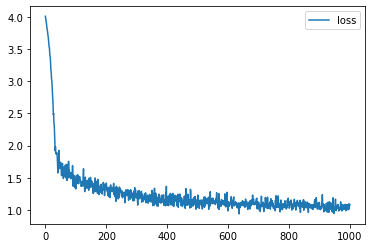

In [91]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    predictions_logp = logp_seq[:, :-1] 
    actual_next_tokens = batch_ix[:, 1:] 

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )
    
    
    # train with backprop
   
    loss.backward()
    opt.step()
    opt.zero_grad() #лучше конечно в начало ставить
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."